In [52]:
import os
import sys
import time 
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import nn_ops
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Layer
from tensorflow.python.keras.layers.core import Activation, Reshape
from tensorflow.python.keras.layers.convolutional import Convolution2D, UpSampling2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [51]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

In [35]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 7: FSD
TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7))
# MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH1,MASK_PATH7))
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids1,train_ids7))
# mask_ids = np.concatenate((mask_ids8,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids1,mask_ids7))

TRAIN_PATH = np.concatenate((TRAIN_PATH2,TRAIN_PATH5,TRAIN_PATH4,TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7,TRAIN_PATH3))
MASK_PATH = np.concatenate((MASK_PATH2,MASK_PATH5,MASK_PATH4,MASK_PATH6,MASK_PATH1,MASK_PATH7,MASK_PATH3))
train_ids = np.concatenate((train_ids2,train_ids5,train_ids4,train_ids6,train_ids1,train_ids7,train_ids3))
mask_ids = np.concatenate((mask_ids2,mask_ids5,mask_ids4,mask_ids6,mask_ids1,mask_ids7,mask_ids3))

In [36]:
# MANUAL PERMUTATION
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
DATA = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 4))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)

strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]
    
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    path = strs_mask[g[n]]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, Needed to make labels 0's and 1's only   
    else:
        img = img > 0
    Y_train[n] = img      

Getting and resizing train images and masks ... 


In [37]:
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

TRAIN_PATH = TRAIN_PATH8
MASK_PATH = MASK_PATH8
train_ids = train_ids8
mask_ids = mask_ids8

# Add abodmen pictures to the beginning
X_train1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + train_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train1[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, Needed to make labels 0's and 1's only   
    else:
        img = img > 0
    Y_train1[n] = img   
    
X_train = np.concatenate((X_train1,X_train),axis=0)
Y_train = np.concatenate((Y_train1,Y_train),axis=0)

Getting and resizing train images and masks ... 


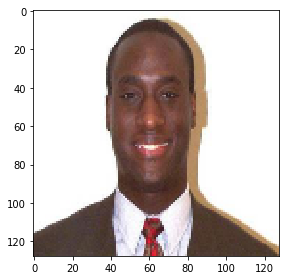

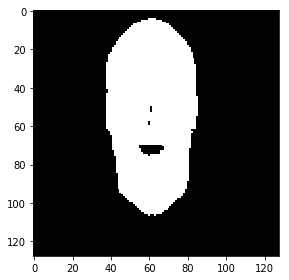

In [43]:
# Check if training data looks all right
train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids1))
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [48]:
# Build SEGNET model
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
n_labels = 2
output_mode = "softmax"

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encoder

conv_1 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
conv_2 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

pool_1 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(pool_1)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)
conv_4 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation("relu")(conv_4)

pool_2 = MaxPooling2D((2,2))(conv_4)

conv_5 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(pool_2)
conv_5 = BatchNormalization()(conv_5)
conv_5 = Activation("relu")(conv_5)
conv_6 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_5)
conv_6 = BatchNormalization()(conv_6)
conv_6 = Activation("relu")(conv_6)
conv_7 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_6)
conv_7 = BatchNormalization()(conv_7)
conv_7 = Activation("relu")(conv_7)

pool_3 = MaxPooling2D((2,2))(conv_7)

conv_8 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(pool_3)
conv_8 = BatchNormalization()(conv_8)
conv_8 = Activation("relu")(conv_8)
conv_9 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_8)
conv_9 = BatchNormalization()(conv_9)
conv_9 = Activation("relu")(conv_9)
conv_10 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_9)
conv_10 = BatchNormalization()(conv_10)
conv_10 = Activation("relu")(conv_10)

pool_4 = MaxPooling2D((2,2))(conv_10)

conv_11 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(pool_4)
conv_11 = BatchNormalization()(conv_11)
conv_11 = Activation("relu")(conv_11)
conv_12 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_11)
conv_12 = BatchNormalization()(conv_12)
conv_12 = Activation("relu")(conv_12)
conv_13 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_12)
conv_13 = BatchNormalization()(conv_13)
conv_13 = Activation("relu")(conv_13)

pool_5 = MaxPooling2D((2,2))(conv_13)

# Decoder

unpool_1 = UpSampling2D((2,2))(pool_5)

conv_14 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_1)
conv_14 = BatchNormalization()(conv_14)
conv_14 = Activation("relu")(conv_14)
conv_15 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_14)
conv_15 = BatchNormalization()(conv_15)
conv_15 = Activation("relu")(conv_15)
conv_16 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_15)
conv_16 = BatchNormalization()(conv_16)
conv_16 = Activation("relu")(conv_16)

unpool_2 = UpSampling2D((2,2))(conv_16)

conv_17 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_2)
conv_17 = BatchNormalization()(conv_17)
conv_17 = Activation("relu")(conv_17)
conv_18 = Convolution2D(512, (3, 3), kernel_initializer='he_normal', padding="same")(conv_17)
conv_18 = BatchNormalization()(conv_18)
conv_18 = Activation("relu")(conv_18)
conv_19 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_18)
conv_19 = BatchNormalization()(conv_19)
conv_19 = Activation("relu")(conv_19)

unpool_3 = UpSampling2D((2,2))(conv_19)

conv_20 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_3)
conv_20 = BatchNormalization()(conv_20)
conv_20 = Activation("relu")(conv_20)
conv_21 = Convolution2D(256, (3, 3), kernel_initializer='he_normal', padding="same")(conv_20)
conv_21 = BatchNormalization()(conv_21)
conv_21 = Activation("relu")(conv_21)
conv_22 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(conv_21)
conv_22 = BatchNormalization()(conv_22)
conv_22 = Activation("relu")(conv_22)

unpool_4 = UpSampling2D((2,2))(conv_22)

conv_23 = Convolution2D(128, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_4)
conv_23 = BatchNormalization()(conv_23)
conv_23 = Activation("relu")(conv_23)
conv_24 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(conv_23)
conv_24 = BatchNormalization()(conv_24)
conv_24 = Activation("relu")(conv_24)

unpool_5 = UpSampling2D((2,2))(conv_24)

conv_25 = Convolution2D(64, (3, 3), kernel_initializer='he_normal', padding="same")(unpool_5)
conv_25 = BatchNormalization()(conv_25)
conv_25 = Activation("relu")(conv_25)

conv_26 = Convolution2D(1, (1, 1), kernel_initializer='he_normal', padding="valid")(conv_25)
conv_26 = BatchNormalization()(conv_26)
# conv_26 = Reshape((128*128, 2), input_shape=(128, 128, 2))(conv_26)
outputs = Activation("softmax")(conv_26)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('model-segnet-21Mar2019.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=64, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

Train on 6828 samples, validate on 1707 samples
Epoch 1/50
1152/6828 [====>.........................] - ETA: 31:36 - loss: 753.8263 - acc: 0.2612